github link: https://github.com/ShlomiFridman/PhoenixProject2025

In [ ]:
!pip install requests beautifulsoup4
!pip install requests beautifulsoup4 nltk
!pip install firebase

In [ ]:
import requests
import time
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from urllib.robotparser import RobotFileParser
from nltk.stem import PorterStemmer
import re
from firebase import firebase

In [ ]:
FBconn = firebase.FirebaseApplication('https://lab6-b3d64-default-rtdb.europe-west1.firebasedatabase.app/',None)

functions for building an index for a page

In [ ]:
def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

functions to handle the crawling

In [ ]:
# Function to fetch and parse the robots.txt file to check permissions
def check_robot(url):
    robot_url = urljoin(url, '/robots.txt')
    rp = RobotFileParser()
    rp.set_url(robot_url)
    # Fetch and parse robots.txt file
    rp.read()
    return rp

In [ ]:
# Function to fetch and parse a page
def fetch_page_crawler(url, rp):
    # Check if the URL is allowed to be crawled according to robots.txt
    if not rp.can_fetch('*', url):  # '*' means all user agents
        print(f"Blocked by robots.txt: {url}")
        return None

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()  # Will raise an exception for 4xx or 5xx responses
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [ ]:
# Function to extract internal links from a page
def extract_links(page_content, base_url):
    soup = BeautifulSoup(page_content, 'html.parser')
    links = set()

    # Find all anchor tags and extract the href attribute
    for anchor in soup.find_all('a', href=True):
        href = anchor['href']

        # Resolve relative URLs to absolute URLs
        full_url = urljoin(base_url, href)

        # Only add links that are within the same domain (ibm.com)
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            links.add(full_url)

    return links

In [ ]:
# Function to crawl a website and fetch n pages
def crawl_website(base_url, max_pages):
    rp = check_robot(base_url)  # Check the robots.txt file
    crawled_urls = set()  # Set to avoid revisiting pages
    urls_to_crawl = [base_url]  # Initialize the queue with the base URL
    crawled_count = 0  # Counter for the number of crawled pages
    urls_index = {}
    ignore_urls = ["form", "mp3", "mp4", "downloads"]

    while urls_to_crawl and crawled_count < max_pages:
        current_url = urls_to_crawl.pop(0)

        if current_url in crawled_urls:
            continue  # Skip already crawled URLs

        print(f"Crawling {crawled_count+1}: {current_url}")
        page_content = fetch_page_crawler(current_url, rp)

        if page_content:
            crawled_urls.add(current_url)
            crawled_count += 1

            # Extract and queue new links to crawl
            new_links = extract_links(page_content, base_url)
            for link in new_links:
                cond1 = any(bad_url in link for bad_url in ignore_urls)
                cond2 = any(u for u in crawled_urls if (f"{u}#" in link))
                cond = cond1 or cond2
                if link not in crawled_urls and link not in urls_to_crawl and not cond:
                    urls_to_crawl.append(link)

            soup = BeautifulSoup(page_content, 'html.parser')
            u_index = index_words(soup)
            u_index = remove_stop_words(u_index)
            u_index = apply_stemming(u_index)
            urls_index[current_url] = u_index
            # Delay between requests to avoid overwhelming the server
            time.sleep(2)  # Sleep for 2 seconds between requests (politeness)

    print(f"\nCrawled {crawled_count} pages.")
    return crawled_urls, urls_index

firebase functions

In [ ]:
def get_index_from_DB():
  return FBconn.get('/Index/', None)

In [ ]:
def update_index_in_db(index_p):
  for k,v in index_p.items():
    FBconn.put("/Index/", k, v)
    print(f"update made:\n\tIndex={k}\ntValues={v}")
  print("Updated given index in DB")

The index we defined

In [ ]:
init_index = [
    'private',
    'public',
    'hybrid',
    'SAAS',
    'PAAS',
    'IAAS',
    'study',
    'chatbot',
    'engine',
    'AI'
]

Processing the index and saving it in DB

In [ ]:
stemmer = PorterStemmer()
stemmed_init_index = {}
for i in init_index:
  stemmed_i = stemmer.stem(i)
  stemmed_init_index[stemmed_i] = {"original_index":i, "cntr":0}

update_index_in_db(stemmed_init_index)

update made:
	Index=privat
tValues={'original_index': 'private', 'cntr': 0}
update made:
	Index=public
tValues={'original_index': 'public', 'cntr': 0}
update made:
	Index=hybrid
tValues={'original_index': 'hybrid', 'cntr': 0}
update made:
	Index=saa
tValues={'original_index': 'SAAS', 'cntr': 0}
update made:
	Index=paa
tValues={'original_index': 'PAAS', 'cntr': 0}
update made:
	Index=iaa
tValues={'original_index': 'IAAS', 'cntr': 0}
update made:
	Index=studi
tValues={'original_index': 'study', 'cntr': 0}
update made:
	Index=chatbot
tValues={'original_index': 'chatbot', 'cntr': 0}
update made:
	Index=engin
tValues={'original_index': 'engine', 'cntr': 0}
update made:
	Index=ai
tValues={'original_index': 'AI', 'cntr': 0}
Updated given index in DB


In [ ]:
# Set the base URL for the IBM website or any other URL to crawl
BASE_URL = 'https://www.ibm.com/us-en'

# To limit the number of pages to crawl
MAX_PAGES = 200

urls, urls_index = crawl_website(BASE_URL, MAX_PAGES)

Crawling 1: https://www.ibm.com/us-en
Crawling 2: https://www.ibm.com/artificial-intelligence?lnk=ProdC
Crawling 3: https://www.ibm.com/consulting?lnk=ProdC
Crawling 4: https://www.ibm.com/impact/ai-ethics?lnk=bus


KeyboardInterrupt: 

In [ ]:
index_from_DB = get_index_from_DB()
for k,v in index_from_DB.items():
  v['urls'] = []
  v["cntr"] = 0
print(index_from_DB)

{'ai': {'cntr': 0, 'original_index': 'AI', 'urls': []}, 'chatbot': {'cntr': 0, 'original_index': 'chatbot', 'urls': []}, 'engin': {'cntr': 0, 'original_index': 'engine', 'urls': []}, 'hybrid': {'cntr': 0, 'original_index': 'hybrid', 'urls': []}, 'iaa': {'cntr': 0, 'original_index': 'IAAS', 'urls': []}, 'paa': {'cntr': 0, 'original_index': 'PAAS', 'urls': []}, 'privat': {'cntr': 0, 'original_index': 'private', 'urls': []}, 'public': {'cntr': 0, 'original_index': 'public', 'urls': []}, 'saa': {'cntr': 0, 'original_index': 'SAAS', 'urls': []}, 'studi': {'cntr': 0, 'original_index': 'study', 'urls': []}}


In [ ]:
for u,u_vals in urls_index.items():
    print(f"Indexing url={u}")
    # soup = fetch_page(u)
    # if soup is None:
    #     continue
    # index = index_words(soup)
    # index = remove_stop_words(index)
    # index = apply_stemming(index)
    for our_ind, our_ind_vals in index_from_DB.items():
      if our_ind in u_vals:
        our_ind_vals['cntr'] += u_vals[our_ind]
        our_ind_vals['urls'].append(u)

print("Finish indexing process")

NameError: name 'urls_index' is not defined

In [ ]:
for ind,vals in index_from_DB.items():
  urls_str = '\n\t\t'.join(vals['urls'])
  print(f"Index: '{ind}'\n\tTotal Count: {vals['cntr']}\n\tUrls: {urls_str}")

Index: 'ai'
	Total Count: 0
	Urls: 
Index: 'chatbot'
	Total Count: 0
	Urls: 
Index: 'engin'
	Total Count: 0
	Urls: 
Index: 'hybrid'
	Total Count: 0
	Urls: 
Index: 'iaa'
	Total Count: 0
	Urls: 
Index: 'paa'
	Total Count: 0
	Urls: 
Index: 'privat'
	Total Count: 0
	Urls: 
Index: 'public'
	Total Count: 0
	Urls: 
Index: 'saa'
	Total Count: 0
	Urls: 
Index: 'studi'
	Total Count: 0
	Urls: 


In [ ]:
update_index_in_db(index_from_DB)

update made:
	Index=ai
tValues={'cntr': 0, 'original_index': 'AI', 'urls': []}
update made:
	Index=chatbot
tValues={'cntr': 0, 'original_index': 'chatbot', 'urls': []}
update made:
	Index=engin
tValues={'cntr': 0, 'original_index': 'engine', 'urls': []}
update made:
	Index=hybrid
tValues={'cntr': 0, 'original_index': 'hybrid', 'urls': []}
update made:
	Index=iaa
tValues={'cntr': 0, 'original_index': 'IAAS', 'urls': []}
update made:
	Index=paa
tValues={'cntr': 0, 'original_index': 'PAAS', 'urls': []}
update made:
	Index=privat
tValues={'cntr': 0, 'original_index': 'private', 'urls': []}
update made:
	Index=public
tValues={'cntr': 0, 'original_index': 'public', 'urls': []}
update made:
	Index=saa
tValues={'cntr': 0, 'original_index': 'SAAS', 'urls': []}
update made:
	Index=studi
tValues={'cntr': 0, 'original_index': 'study', 'urls': []}
Updated given index in DB


<ipython-input-25-d1456ca61007>:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(x="Index", y="Appearances",


<Figure size 640x480 with 0 Axes>

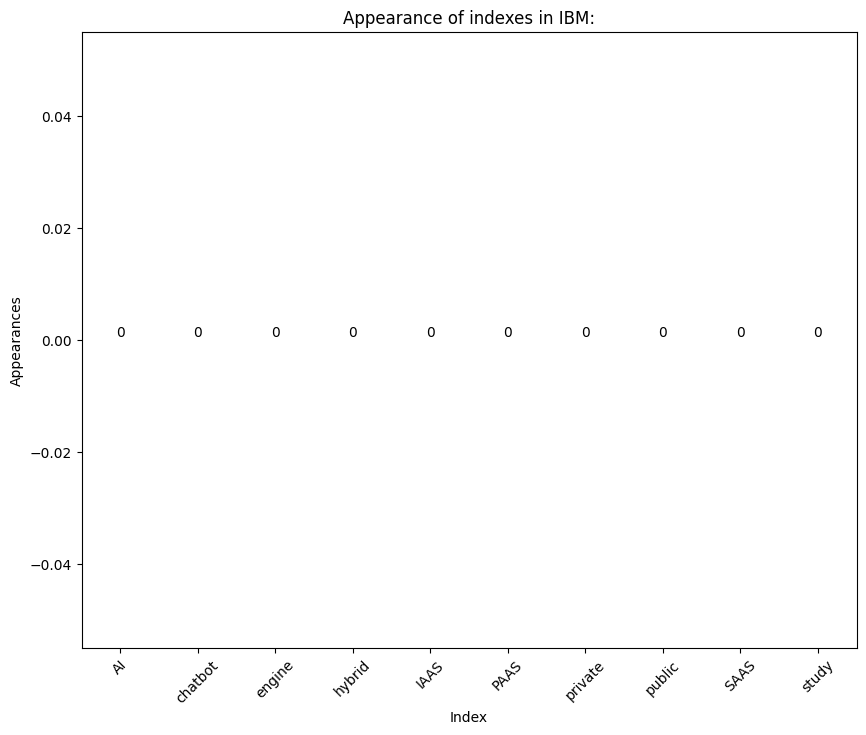

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ind_names = [ind["original_index"] for ind in index_from_DB.values()]
ind_cntrs = [ind["cntr"] for ind in index_from_DB.values()]
ind_data = pd.DataFrame({
    "Index":ind_names,
    "Appearances":ind_cntrs
})

plt.clf()  # Clear the current figure
plt.figure(figsize=(10, 8))  # Increased figure size to accommodate labels
plt.title("Appearance of indexes in IBM:")

ax = sns.barplot(x="Index", y="Appearances",
                 errwidth=0, data=ind_data)
for i in ax.containers:
  ax.bar_label(i,)
plt.xticks(rotation=45)
plt.show()  # Add this to display the plot
plt.close()  # Close the figure to free memory

In [ ]:
searchHistory = []

TODO search engine by text field, you can use the code from exercise 6, save the search history

TODO 3 tabs: search results, graph that shows the rank of each page, graph for the website cover of the query keywords

TODO add the group logo from drive

TODO enable shering, make the link public